
# P300 Decoding

This example runs a set of machine learning algorithms on the P300 cats/dogs
dataset, and compares them in terms of classification performance. 

The data used is exactly the same as in the P300 `load_and_visualize` example. 


## Setup



In [1]:
# Some standard pythonic imports
import warnings
warnings.filterwarnings('ignore')
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt

# MNE functions
from mne import Epochs,find_events
from mne.decoding import Vectorizer

# EEG-Notebooks functions
from eegnb.analysis.analysis_utils import load_data
from eegnb.datasets import fetch_dataset

# Scikit-learn and Pyriemann ML functionalities
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

## One subject, One session

### Load Data


In [ ]:
current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(current_dir, '..'))
eegnb_data_path = os.path.join(base_dir, 'data')
p300_data_path = os.path.join(eegnb_data_path, 'visual-P300', 'eegnb_examples')

# If dataset hasn't been downloaded yet, download it 
if not os.path.isdir(p300_data_path):
    fetch_dataset(data_dir=eegnb_data_path, experiment='visual-P300', site='eegnb_examples')        


subject = 1
session = 1
raw = load_data(subject,session,
                experiment='visual-P300', site='eegnb_examples', device_name='muse2016',
                data_dir = eegnb_data_path)

raw.filter(1,30, method='iir')

# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(raw)
event_id = {'Non-Target': 1, 'Target': 2}
epochs = Epochs(raw, events=events, event_id=event_id,
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 100e-6}, preload=True,
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

epochs



Loading these files: 

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-P300\eegnb_examples\muse2016\subject0001\session001\data_2017-02-04-15_45_13.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-P300\eegnb_examples\muse2016\subject0001\session001\data_2017-02-04-15_47_49.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-P300\eegnb_examples\muse2016\subject0001\session001\data_2017-02-04-15_51_07.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-P300\eegnb_examples\muse2016\subject0001\session001\data_2017-02-04-15_55_07.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-P300\eegnb_examples\muse2016\subject0001\session001\data_2017-02-04-15_58_30.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-P300\eegnb_examples

<Epochs | 1143 events (all good), -0.102 – 0.801 s (baseline off), ~8.1 MiB, data loaded,
 'Non-Target': 959
 'Target': 184>

### Run Classfication



NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


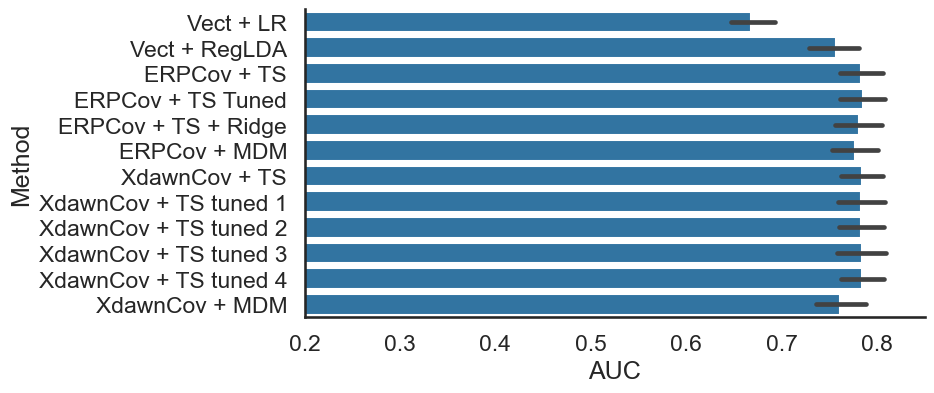

In [3]:
clfs = OrderedDict()
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERPCov + TS Tuned'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression(C=0.1, class_weight='balanced'))
clfs['ERPCov + TS + Ridge'] = make_pipeline(
    ERPCovariances(estimator='oas'),
    TangentSpace(),
    RidgeClassifierCV(alphas=[0.1,1,10], scoring='roc_auc', cv=3)
)
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + TS tuned 1'] = make_pipeline(
    XdawnCovariances(estimator='lwf', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.1, class_weight='balanced')
)
clfs['XdawnCov + TS tuned 2'] = make_pipeline(
    XdawnCovariances(estimator='lwf', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.05, class_weight='balanced')
)
clfs['XdawnCov + TS tuned 3'] = make_pipeline(
    XdawnCovariances(estimator='oas', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.1, class_weight='balanced')
)
clfs['XdawnCov + TS tuned 4'] = make_pipeline(
    XdawnCovariances(estimator='oas', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.05, class_weight='balanced')
)
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=(8, 4))
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()

In [4]:
# Create DataFrame
results_auc = pd.DataFrame({'AUC': auc, 'Method': methods})

# Function to print summary with max possible AUC
def print_summary_with_max(df, metric_name):
    print(f"\n{metric_name} summary:")
    summary = df.groupby('Method')[metric_name].agg(['mean','std']).round(3)
    # Add max possible column (mean + std, capped at 1)
    summary['max_possible'] = (summary['mean'] + summary['std']).clip(upper=1.0)
    print(summary)

# Print summary
print_summary_with_max(results_auc, 'AUC')


AUC summary:
                        mean    std  max_possible
Method                                           
ERPCov + MDM           0.777  0.041         0.818
ERPCov + TS            0.784  0.039         0.823
ERPCov + TS + Ridge    0.781  0.041         0.822
ERPCov + TS Tuned      0.786  0.040         0.826
Vect + LR              0.668  0.039         0.707
Vect + RegLDA          0.757  0.046         0.803
XdawnCov + MDM         0.762  0.044         0.806
XdawnCov + TS          0.784  0.038         0.822
XdawnCov + TS tuned 1  0.784  0.041         0.825
XdawnCov + TS tuned 2  0.783  0.040         0.823
XdawnCov + TS tuned 3  0.784  0.041         0.825
XdawnCov + TS tuned 4  0.784  0.039         0.823


## All subjects, All sessions

### Load Data

In [ ]:
from mne import concatenate_epochs

current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(current_dir, '..'))
eegnb_data_path = os.path.join(base_dir, 'data')
p300_data_path = os.path.join(eegnb_data_path, 'visual-P300', 'eegnb_examples')

# Download dataset if missing
if not os.path.isdir(p300_data_path):
    fetch_dataset(data_dir=eegnb_data_path, experiment='visual-P300', site='eegnb_examples')

# Subject → available session mapping
sub_sess = {
    1: [1, 2, 3],
    2: [1, 2],
    3: [1, 2, 3],
    4: [1],
    5: [1]
}

event_id = {'Non-Target': 1, 'Target': 2}
all_epochs = []

# Load only listed subjects/sessions
for subj, sessions in sub_sess.items():
    for sess in sessions:
        try:
            print(f"Loading Subject {subj}, Session {sess}...")
            raw = load_data(
                subj, sess,
                experiment='visual-P300',
                site='eegnb_examples',
                device_name='muse2016',
                data_dir=eegnb_data_path
            )
            raw.filter(1,30, method='iir')
            events = find_events(raw)
            temp_epochs = Epochs(
                raw, events=events, event_id=event_id,
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 100e-6}, preload=True,
                verbose=False, picks=[0,1,2,3])
            print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
            all_epochs.append(temp_epochs)
            print(f"Loaded Subject {subj}, Session {sess} — {len(temp_epochs)} epochs")

        except Exception as e:
            print(f"Skipping Subject {subj}, Session {sess}: {e}")

# Concatenate all loaded epochs
if all_epochs:
    all_epochs = concatenate_epochs(all_epochs)
    print(f"\nTotal combined epochs: {len(all_epochs)}")
else:
    raise RuntimeError("No valid epochs found — check subject/session availability.")


Loading Subject 1, Session 1...


Loading these files: 

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-P300\eegnb_examples\muse2016\subject0001\session001\data_2017-02-04-15_45_13.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-P300\eegnb_examples\muse2016\subject0001\session001\data_2017-02-04-15_47_49.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-P300\eegnb_examples\muse2016\subject0001\session001\data_2017-02-04-15_51_07.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-P300\eegnb_examples\muse2016\subject0001\session001\data_2017-02-04-15_55_07.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-P300\eegnb_examples\muse2016\subject0001\session001\data_2017-02-04-15_58_30.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb

### Run Classification

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


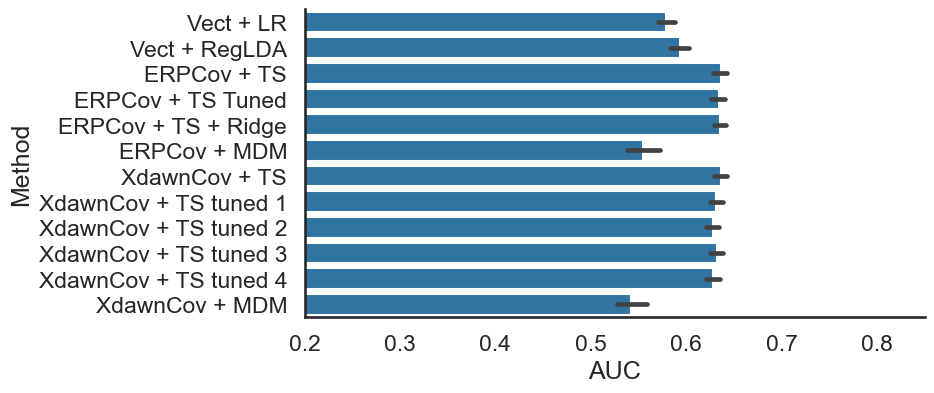

In [6]:
clfs = OrderedDict()
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERPCov + TS Tuned'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression(C=0.1, class_weight='balanced'))
clfs['ERPCov + TS + Ridge'] = make_pipeline(
    ERPCovariances(estimator='oas'),
    TangentSpace(),
    RidgeClassifierCV(alphas=[0.1,1,10], scoring='roc_auc', cv=3)
)
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + TS tuned 1'] = make_pipeline(
    XdawnCovariances(estimator='lwf', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.1, class_weight='balanced')
)
clfs['XdawnCov + TS tuned 2'] = make_pipeline(
    XdawnCovariances(estimator='lwf', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.05, class_weight='balanced')
)
clfs['XdawnCov + TS tuned 3'] = make_pipeline(
    XdawnCovariances(estimator='oas', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.1, class_weight='balanced')
)
clfs['XdawnCov + TS tuned 4'] = make_pipeline(
    XdawnCovariances(estimator='oas', nfilter=3),
    TangentSpace(),
    LogisticRegression(C=0.05, class_weight='balanced')
)
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

# format data
all_epochs.pick_types(eeg=True)
X = all_epochs.get_data() * 1e6
times = all_epochs.times
y = all_epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=(8, 4))
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()

In [7]:
# Create DataFrame
results_auc = pd.DataFrame({'AUC': auc, 'Method': methods})

# Function to print summary with max possible AUC
def print_summary_with_max(df, metric_name):
    print(f"\n{metric_name} summary:")
    summary = df.groupby('Method')[metric_name].agg(['mean','std']).round(3)
    # Add max possible column (mean + std, capped at 1)
    summary['max_possible'] = (summary['mean'] + summary['std']).clip(upper=1.0)
    print(summary)

# Print summary
print_summary_with_max(results_auc, 'AUC')


AUC summary:
                        mean    std  max_possible
Method                                           
ERPCov + MDM           0.555  0.029         0.584
ERPCov + TS            0.636  0.012         0.648
ERPCov + TS + Ridge    0.636  0.012         0.648
ERPCov + TS Tuned      0.634  0.012         0.646
Vect + LR              0.579  0.016         0.595
Vect + RegLDA          0.593  0.017         0.610
XdawnCov + MDM         0.542  0.028         0.570
XdawnCov + TS          0.636  0.012         0.648
XdawnCov + TS tuned 1  0.632  0.012         0.644
XdawnCov + TS tuned 2  0.628  0.012         0.640
XdawnCov + TS tuned 3  0.633  0.012         0.645
XdawnCov + TS tuned 4  0.628  0.012         0.640
